[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain

## Review(復習)

ノード、通常エッジ、条件付きエッジを使用してシンプルなグラフを作成しました。

## Goals

次に、4つの[概念](https://python.langchain.com/v0.2/docs/concepts/)を組み合わせたシンプルなチェーンを作成してみましょう。

* [チャットメッセージ](https://python.langchain.com/v0.2/docs/concepts/#messages) をグラフの状態として使用する
* [チャットモデル](https://python.langchain.com/v0.2/docs/concepts/#chat-models) をグラフノードで使用する
* [バインディングツール](https://python.langchain.com/v0.2/docs/concepts/#tools) をチャットモデルに適用
* グラフノードで[ツール呼び出しを実行](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling)

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

注意: リンクはlangchain v0.2のドキュメントにリンクしているものの、poetryで環境を作るとlangchain v0.3を使用しているはずです。

In [1]:
# poetryを使っている場合は特にインストール不要
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## Messages

チャットモデルは [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) を使用でき、会話内のさまざまな役割を担います。

LangChain は、`HumanMessage`、`AIMessage`、`SystemMessage`、`ToolMessage` など、さまざまなメッセージタイプをサポートしています。

これらは、ユーザーからのメッセージ、チャットモデルからのメッセージ、チャットモデルが動作を指示するためのメッセージ、ツール呼び出しからのメッセージを表します。

メッセージのリストを作成してみましょう。

各メッセージには、いくつかの情報を付与することができます。

* `content` - メッセージの内容
* `name` - 追加任意。メッセージの送信者
* `response_metadata` - 追加任意。メタデータの辞書(例えば、モデルプロバイダが `AIMessages` 用に用意することが多い)





In [1]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content="So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content="Yes, that's right.", name="Lance"))
messages.append(AIMessage(content="Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content="I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat Models

[チャットモデル](https://python.langchain.com/v0.2/docs/concepts/#chat-models) は、メッセージのシーケンスを入力として使用し、前述のとおり、メッセージタイプをサポートすることができます。

選択肢はたくさんあります(https://python.langchain.com/v0.2/docs/concepts/#chat-models)。OpenAIで作業してみましょう。

`OPENAI_API_KEY` が設定されていることを確認し、設定されていない場合は入力するように求められます。


注意: リンクはlangchain v0.2のドキュメントにリンクしているものの、poetryで環境を作るとlangchain v0.3を使用しているはずです。

In [2]:
import os
import getpass


def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

チャットモデルを読み込んで、メッセージの一覧を表示せずに呼び出すことができます。

その結果は、特定の `response_metadata` を持つ `AIMessage` であることがわかります。


In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-2024-08-06")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [4]:
result

AIMessage(content='The best place to see orcas in the United States is typically considered to be the Pacific Northwest, particularly the waters around the San Juan Islands in Washington State. These islands are located in the Salish Sea and are well-known for their resident orca pods. The best time to see orcas in the San Juan Islands is usually from late spring through early fall, with peak viewing opportunities often occurring between May and September.\n\nThere are several whale-watching tours available in the area that offer guided trips to see orcas and other marine wildlife. Additionally, the Lime Kiln Point State Park on San Juan Island, often referred to as "Whale Watch Park," is a popular spot for land-based whale watching, as orcas frequently pass close to the shore.\n\nOther notable locations for orca sightings in the US include the coast of Monterey Bay in California and the waters around Southeast Alaska. However, the San Juan Islands remain one of the most reliable and a

In [5]:
result.response_metadata

{'token_usage': {'completion_tokens': 202,
  'prompt_tokens': 67,
  'total_tokens': 269,
  'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_6b68a8204b',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

モデルに外部システムとやり取りさせたい場合には、Tool が便利です。

外部システム(APIなど)では、自然言語よりも特定の入力スキーマやペイロードを必要とする場合がよくあります。

たとえば、APIをtoolとしてバインドすると、モデルに必要な入力スキーマを認識させることができます。

モデルは、ユーザーが入力した自然言語に基づいてtoolを呼び出すことを選択します。 

そして、toolのスキーマに従った出力を返します。

[多くのLLMプロバイダーがツール呼び出しをサポートしています](https://python.langchain.com/v0.1/docs/integrations/chat/)し、LangChainのツール呼び出しインターフェースはシンプルです。

Pythonの任意の`関数`を、`ChatModel.bind_tools(function)`に渡すだけでよいのです。

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

注意: リンクはlangchain v0.1のドキュメントにリンクしているものの、poetryで環境を作るとlangchain v0.3を使用しているはずです。


ツール呼び出し(tool calling)の簡単な例を見てみましょう!

`multiply` 関数が私たちのtoolです。



In [6]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


llm_with_tools = llm.bind_tools([multiply])

例えば「2に3を掛けると何になるか」のような入力値を渡すと、ツール呼び出しが返されます。

ツール呼び出しには、呼び出す関数の名前とともに、関数の入力スキーマに一致する引数が含まれています。

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [7]:
tool_call = llm_with_tools.invoke([HumanMessage(content="What is 2 multiplied by 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Phc4KzBIrH8YwgNMZ9mpPDWn', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 62, 'total_tokens': 79, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6b68a8204b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-216be90d-65be-4f71-8f35-f3f17a0c0d99-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_Phc4KzBIrH8YwgNMZ9mpPDWn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 62, 'output_tokens': 17, 'total_tokens': 79, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [8]:
tool_call.additional_kwargs["tool_calls"]

[{'id': 'call_Phc4KzBIrH8YwgNMZ9mpPDWn',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

## メッセージを state として使用

これらの基礎が整ったので、今度はグラフの状態に [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) を使用します。

状態 `MessagesState` を、単一のキー `messages` を持つ `TypedDict` として定義してみましょう。

`messages` は、上で定義したように(例えば、`HumanMessage` など)単にメッセージのリストです。

注意: リンクはlangchain v0.2のドキュメントにリンクしているものの、poetryで環境を作るとlangchain v0.3を使用しているはずです。


In [10]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage


class MessagesState(TypedDict):
    # この定義だと、毎回上書きされる
    messages: list[AnyMessage]

## Reducers

さて、ちょっとした問題が発生しました!

先ほど説明したように、各ノードは状態キー `messages` に新しい値を返します。

しかし、この新しい値は以前の `messages` の値を [上書き](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) します。

グラフが実行されると、私たちは `messages` 状態キーにメッセージを **追加** したいのです。

これには [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) を使用できます。

reducerを使用することで、stateの更新方法を指定することができます。

reducer関数が指定されていない場合、以前にも見たように、キーへの更新はそれを **上書きする** ものと想定されます。

しかし、メッセージを追加するには、あらかじめ用意されている `add_messages` reducerを使用できます。

これにより、すべてのメッセージが既存のメッセージのリストに追加されることが保証されます。

私たちは、`messages` キーに `add_messages` reducer関数をメタデータとしてアノテーションするだけでよいのです。


In [11]:
from typing import Annotated
from langgraph.graph.message import add_messages


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

メッセージのリストがグラフの状態であることはよくあるので、LangGraphにはあらかじめ構築された[`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)があります! 

`MessagesState` は次のように定義されています。

* 事前に構築された単一の `messages` キーを含む。
* `AnyMessage` オブジェクトのリストです。
* `add_messages` リダクタを使用します。

通常は、上記のカスタム `TypedDict` を定義するよりも簡潔であるため、`MessagesState` を使用します。


In [13]:
from langgraph.graph import MessagesState


class MessagesState(MessagesState):
    # メッセージ以外に必要なキーを追加します。これはあらかじめ構築されています。
    pass

もう少し深く掘り下げるために、`add_messages` reducerが単独でどのように動作するのかを見てみましょう。

In [12]:
# Initial state
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(content="I'm looking for information on marine biology.", name="Lance"),
]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='3175f1a6-8b51-487a-a7e7-911f9d346ac1'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='908548fe-6820-4aea-9d35-d059d72f580f'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='e2fa2d27-e970-47fe-ad4b-c9cb623dafd8')]

## Our graph

それでは、`MessagesState` をグラフで使用してみましょう

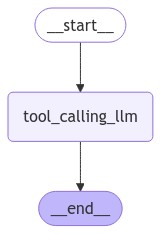

In [14]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage


# Node
def tool_calling_llm(state: MessagesState) -> dict[str, list[BaseMessage]]:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

`Hello!` を渡すと、LLMはツール呼び出しなしで応答します。

In [15]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


LLMは、入力またはタスクがそのツールが提供する機能が必要であると判断した場合に、そのツールを使用することを選択します。


In [16]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3!")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_9RXBiaZtxz7Jllp51bS3oUnz)
 Call ID: call_9RXBiaZtxz7Jllp51bS3oUnz
  Args:
    a: 2
    b: 3
